In [1]:
# Import necessary libraries
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [2]:
# Load the data
gdf = gpd.read_file('final_cleaned_gdf.geojson')

# Check for missing values
print(gdf.isnull().sum())

# Replace NaN values with 'No Spill'
gdf['root_cause'] = gdf['root_cause'].fillna('No Spill')

operator_number                0
flowline_id                    0
location_id                    0
status                         0
location_type                  0
fluid                          0
material                       0
diameter_in                    0
length_ft                      0
max_operating_pressure         0
shape_length                   0
line_age_yr                    0
root_cause                274652
risk                           0
geometry                       0
dtype: int64


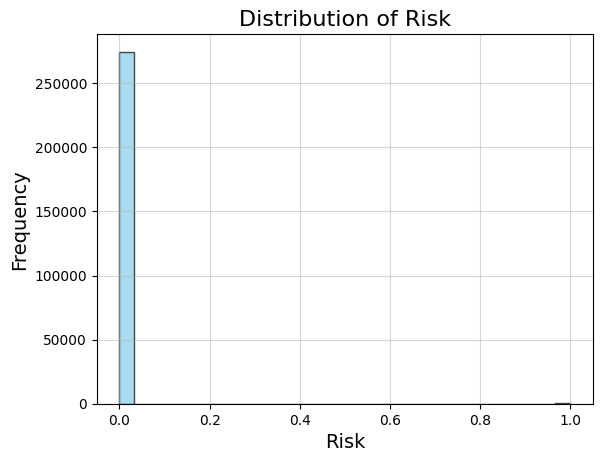

In [3]:
# Plot the distribution of the 'risk' column
plt.hist(gdf['risk'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    
# Add titles and labels
plt.title('Distribution of Risk', fontsize=16)
plt.xlabel('Risk', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.5)
    
# Show the plot
plt.show()

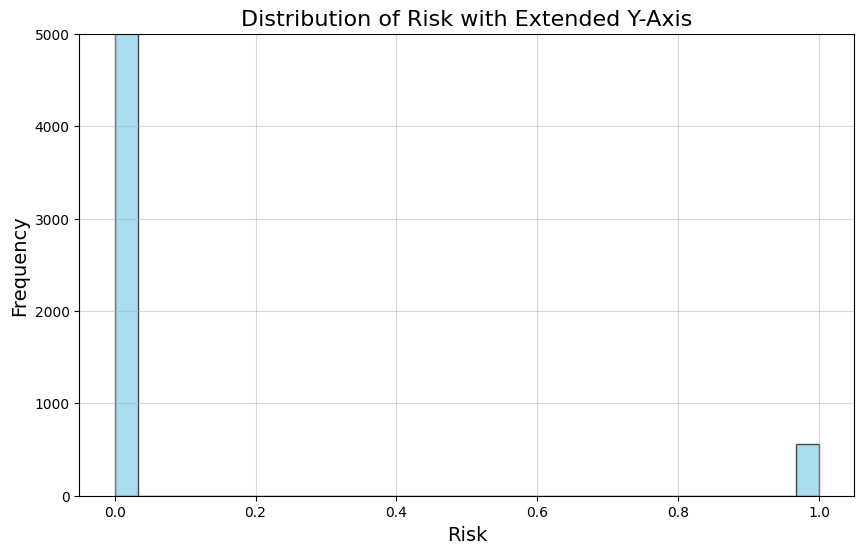

In [4]:
# Adjusting the y-axis to zoom in
plt.figure(figsize=(10, 6))

# Histogram of 'risk'
plt.hist(gdf['risk'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Distribution of Risk with Extended Y-Axis', fontsize=16)
plt.xlabel('Risk', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.ylim(0, 5000)  # Adjust the y-axis to highlight risk = 1
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

In [5]:
# Count the frequency of each unique value in the 'risk' column
if 'risk' in gdf.columns:
    risk_counts = gdf['risk'].value_counts()

    # Display the counts
    print("Counts of unique risk values:")
    print(risk_counts)
else:
    print("The 'risk' column is not found in the dataset.")

Counts of unique risk values:
risk
0    274652
1       562
Name: count, dtype: int64


In [6]:
print(gdf.columns)

Index(['operator_number', 'flowline_id', 'location_id', 'status',
       'location_type', 'fluid', 'material', 'diameter_in', 'length_ft',
       'max_operating_pressure', 'shape_length', 'line_age_yr', 'root_cause',
       'risk', 'geometry'],
      dtype='object')


In [7]:
# List of categorical variables
categorical_vars = ['status', 'location_type', 'fluid', 'material', 'root_cause', 'operator_number', 'flowline_id', 'location_id']
# List of numerical variables
numerical_vars = ['diameter_in', 'length_ft', 'max_operating_pressure',
                  'shape_length', 'line_age_yr']

# Perform one-hot encoding
gdf_encoded = pd.get_dummies(gdf, columns=categorical_vars, drop_first=True)

# Keep geometry for later use
gdf_geometry = gdf[['geometry']]

# Exclude geometry from the features
gdf_encoded = gdf_encoded.drop('geometry', axis=1)

# Define the feature matrix X and target vector y
X = gdf_encoded.drop('risk', axis=1)
y = gdf_encoded['risk']

# Standardize numerical features
scaler = StandardScaler()
X[numerical_vars] = scaler.fit_transform(X[numerical_vars])

# Similarity Matrix

In [8]:
# Subset of instances where risk = 1
X_risk1 = X[y == 1]

# Compute cosine similarity between all instances and risk = 1 instances
similarity_matrix = cosine_similarity(X, X_risk1)

# Average similarity scores for each instance
avg_similarity = similarity_matrix.mean(axis=1)

# Convert to a DataFrame
risk_scores = pd.DataFrame({
    'avg_similarity': avg_similarity
}, index=X.index)

In [9]:
# Normalize the risk scores
min_score = risk_scores['avg_similarity'].min()
max_score = risk_scores['avg_similarity'].max()

risk_scores['risk_probability'] = (
    risk_scores['avg_similarity'] - min_score
) / (max_score - min_score)

# Assign a risk probability of 1 to all risk = 1 instances
risk_scores.loc[y == 1, 'risk_probability'] = 1.0

In [10]:
#  gdf_result is the GeoDataFrame with risk probabilities
gdf_result = gdf.join(risk_scores['risk_probability'])

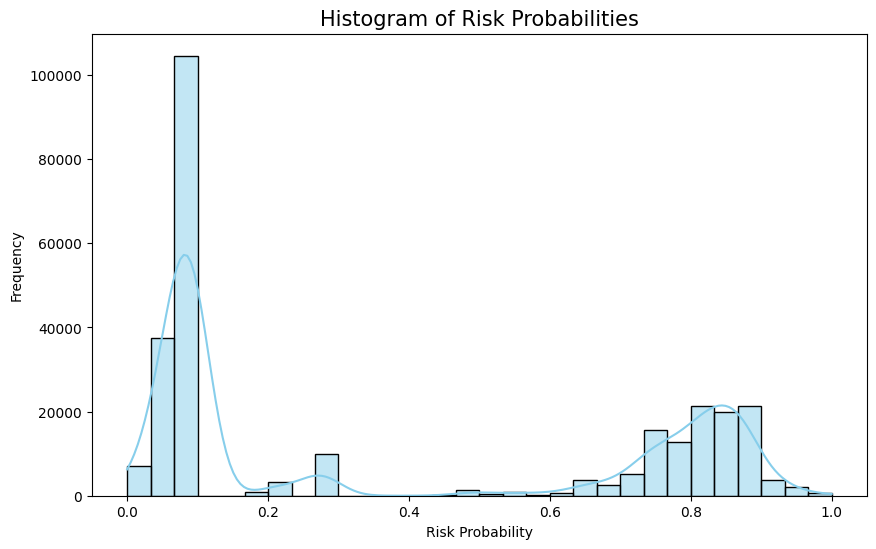

In [11]:
import seaborn as sns

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(gdf_result['risk_probability'], bins=30, kde=True, color='skyblue')

# Add labels and title
plt.title('Histogram of Risk Probabilities', fontsize=15)
plt.xlabel('Risk Probability')
plt.ylabel('Frequency')

# Show the plot
plt.show()

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_16668/1574042676.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r')


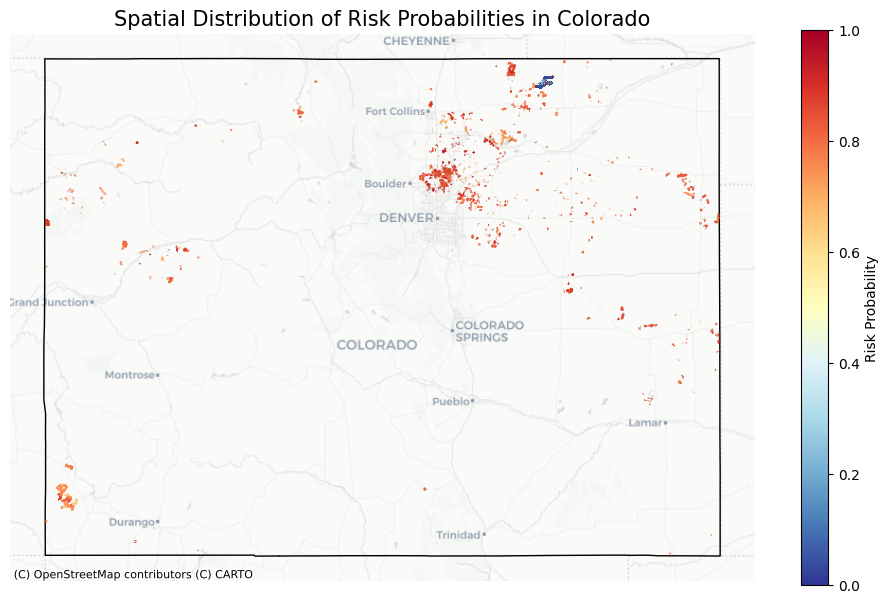

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # Import contextily for basemap

# Read Colorado state boundary
url = 'https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip'
states = gpd.read_file(url)
colorado = states[states['NAME'] == 'Colorado']

# Ensure CRS matches
if gdf_result.crs != colorado.crs:
    gdf_result = gdf_result.to_crs(colorado.crs)

# Clip data to Colorado
gdf_colorado = gpd.clip(gdf_result, colorado)

# Reproject to Web Mercator (EPSG:3857) for contextily
gdf_colorado = gdf_colorado.to_crs(epsg=3857)
colorado = colorado.to_crs(epsg=3857)

# Use reversed 'RdYlBu' colormap which goes from blue to red
cmap = plt.cm.get_cmap('RdYlBu_r')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Colorado boundary
colorado.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot risk probabilities
gdf_colorado.plot(
    column='risk_probability',
    ax=ax,
    cmap=cmap,
    legend=True,
    legend_kwds={
        'label': "Risk Probability",
        'orientation': "vertical",
        'shrink': 0.6
    },
    alpha=0.7
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set title and remove axes
ax.set_title('Spatial Distribution of Risk Probabilities in Colorado', fontsize=15)
ax.set_axis_off()

# Show the plot
plt.show()

# Stats about Risk Probability

In [16]:
# Compute the mean feature vector of risk = 1 instances
X_risk1_mean = X_risk1.mean(axis=0)

In [17]:
from sklearn.preprocessing import normalize

# Convert to numpy arrays
X_array = X.values
X_risk1_mean_array = X_risk1_mean.values.reshape(1, -1)

# Normalize the feature vectors
X_normalized = normalize(X_array, axis=1)
X_risk1_mean_normalized = normalize(X_risk1_mean_array, axis=1)


In [18]:
import numpy as np

# Compute element-wise products (feature contributions)
feature_contributions = X_normalized * X_risk1_mean_normalized

# Sum over features to get similarity scores
similarity_scores = feature_contributions.sum(axis=1)

In [19]:
# Compute average contribution of each feature across all instances
average_feature_contributions = feature_contributions.mean(axis=0)

# Create a DataFrame with feature names and their average contributions
feature_contributions_df = pd.DataFrame({
    'Feature': X.columns,
    'AverageContribution': average_feature_contributions
})

# Sort features by average contribution
feature_contributions_df = feature_contributions_df.sort_values(by='AverageContribution', ascending=False)

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_16668/1321268071.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


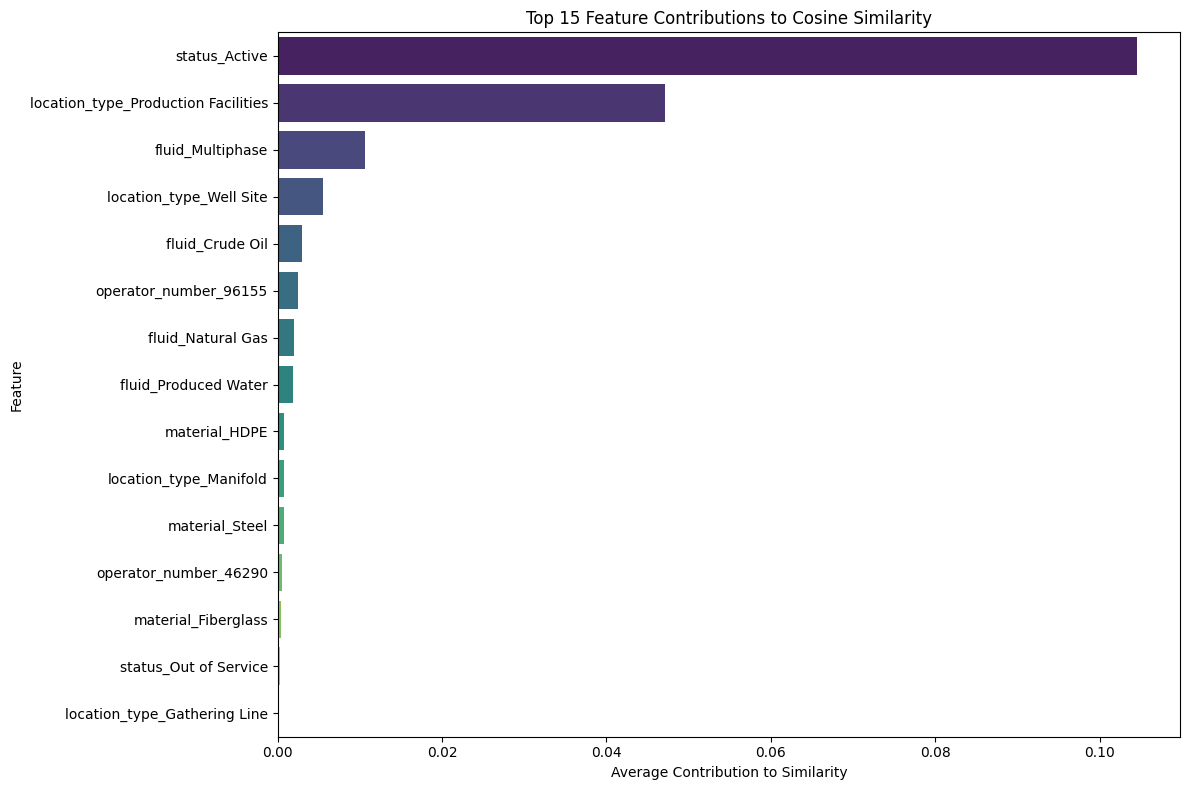

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top 15 features contributing to similarity
plt.figure(figsize=(12, 8))
sns.barplot(
    x='AverageContribution',
    y='Feature',
    data=feature_contributions_df.head(15),
    palette='viridis'
)
plt.title('Top 15 Feature Contributions to Cosine Similarity')
plt.xlabel('Average Contribution to Similarity')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Extreme Value Theory

In [22]:
# For example, use the 95th percentile as the threshold
threshold = gdf_result['risk_probability'].quantile(0.95)

In [23]:
# Calculate exceedances over the threshold
exceedances = risk_scores[risk_scores['risk_probability'] > threshold]['risk_probability'] - threshold

GEV Parameters: Shape=-0.42237267169875126, Location=0.015168471292338673, Scale=0.016953222745118096


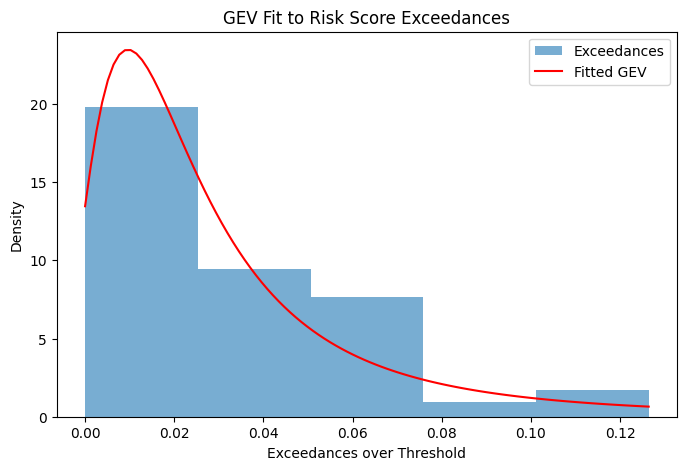

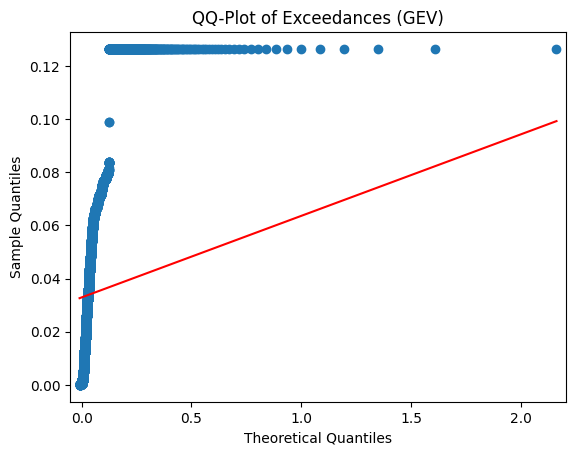

In [37]:
import numpy as np
from scipy.stats import genextreme
import matplotlib.pyplot as plt

# Step 1: Fit the GEV to the exceedances
# Use genextreme to fit the data
gev_params = genextreme.fit(exceedances)

# Extract the parameters
shape, loc, scale = gev_params
print(f'GEV Parameters: Shape={shape}, Location={loc}, Scale={scale}')

# Step 2: Plot GEV Fit to the Exceedances
# Generate points to plot the fitted GEV distribution
x = np.linspace(exceedances.min(), exceedances.max(), 100)
gev_pdf = genextreme.pdf(x, shape, loc=loc, scale=scale)

# Plot the histogram of exceedances and the GEV fit
plt.figure(figsize=(8, 5))
plt.hist(exceedances, bins=5, density=True, alpha=0.6, label='Exceedances')
plt.plot(x, gev_pdf, 'r-', label='Fitted GEV')
plt.xlabel('Exceedances over Threshold')
plt.ylabel('Density')
plt.title('GEV Fit to Risk Score Exceedances')
plt.legend()
plt.show()

# Step 3: QQ-Plot for GEV
from statsmodels.graphics.gofplots import qqplot

# Generate QQ-plot for the exceedances against the fitted GEV distribution
qqplot(
    exceedances,
    dist=genextreme,
    distargs=(shape,),
    loc=loc,
    scale=scale,
    line='s'
)
plt.title('QQ-Plot of Exceedances (GEV)')
plt.show()

In [24]:
# Fit the GPD to the exceedances
params = genpareto.fit(exceedances)
shape, loc, scale = params
print(f'GPD Parameters: Shape={shape}, Location={loc}, Scale={scale}')

GPD Parameters: Shape=-0.10711557975453033, Location=3.7961079209483905e-06, Scale=0.03645689042078068


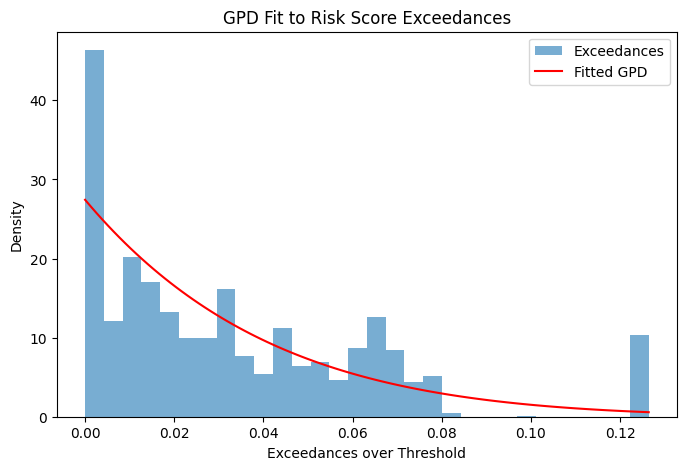

In [25]:
# Plot histogram of exceedances and fitted GPD
x = np.linspace(exceedances.min(), exceedances.max(), 100)
pdf = genpareto.pdf(x, *params)

plt.figure(figsize=(8, 5))
plt.hist(exceedances, bins=30, density=True, alpha=0.6, label='Exceedances')
plt.plot(x, pdf, 'r-', label='Fitted GPD')
plt.xlabel('Exceedances over Threshold')
plt.ylabel('Density')
plt.title('GPD Fit to Risk Score Exceedances')
plt.legend()
plt.show()

In [27]:
# Define a high risk score to estimate exceedance probability
high_risk_score = threshold + 0.1  # Adjust as needed

# Calculate the tail probability
tail_prob = genpareto.sf(high_risk_score - threshold, *params)
print(f'Probability of exceeding a risk score of {high_risk_score:.2f}: {tail_prob:.6f}')

Probability of exceeding a risk score of 0.97: 0.038870


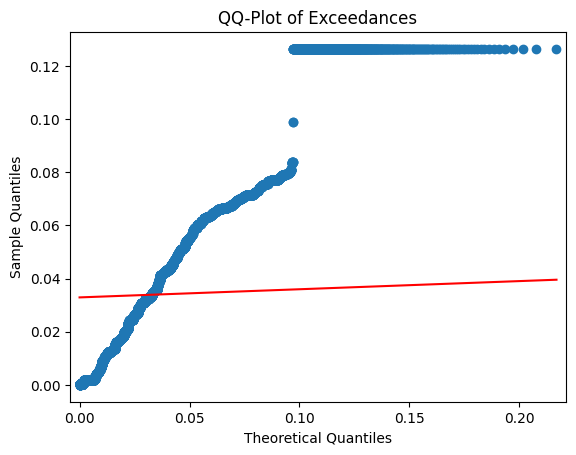

In [33]:
from statsmodels.graphics.gofplots import qqplot

# Extract parameters from the fitted GPD
shape, loc, scale = params

# Generate QQ-plot
qqplot(
    exceedances,               # Your data
    dist=genpareto,            # The GPD
    distargs=(shape,),         # Only the shape parameter
    loc=loc,                   # Specify loc
    scale=scale,               # Specify scale
    line='s'                   # Add a reference line
)
plt.title('QQ-Plot of Exceedances')
plt.show()

# Confidence Intervals

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def bootstrap_similarity(X, X_risk1, n_iterations=1000, random_state=42):
    """
    Perform bootstrapping to estimate confidence intervals for similarity scores.
    
    Parameters:
    - X: Feature matrix for all instances.
    - X_risk1: Feature matrix for risk = 1 instances.
    - n_iterations: Number of bootstrap iterations.
    - random_state: Seed for reproducibility.
    
    Returns:
    - similarity_scores_bootstrap: Array of shape (n_samples, n_iterations)
      containing the similarity scores from each bootstrap iteration.
    """
    np.random.seed(random_state)
    n_samples = X.shape[0]
    similarity_scores_bootstrap = np.zeros((n_samples, n_iterations))
    
    for i in range(n_iterations):
        # Resample indices with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_bootstrap = X.iloc[indices]
        
        # Recompute similarity matrix
        similarity_matrix_bootstrap = cosine_similarity(X_bootstrap, X_risk1)
        avg_similarity_bootstrap = similarity_matrix_bootstrap.mean(axis=1)
        
        # Store the similarity scores
        similarity_scores_bootstrap[:, i] = avg_similarity_bootstrap
        
    return similarity_scores_bootstrap

In [30]:
# Assuming X and X_risk1 are your feature matrices
n_iterations = 1000  # Number of bootstrap iterations
similarity_scores_bootstrap = bootstrap_similarity(X, X_risk1, n_iterations=n_iterations)

KeyboardInterrupt: 

In [ ]:
# Compute the mean similarity score from the original data
similarity_matrix = cosine_similarity(X, X_risk1)
avg_similarity = similarity_matrix.mean(axis=1)

# Compute confidence intervals
confidence_level = 0.95
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100

# Compute percentiles for confidence intervals
ci_lower = np.percentile(similarity_scores_bootstrap, lower_percentile, axis=1)
ci_upper = np.percentile(similarity_scores_bootstrap, upper_percentile, axis=1)

# Create a DataFrame to hold the results
similarity_confidence_df = pd.DataFrame({
    'avg_similarity': avg_similarity,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
}, index=X.index)

In [ ]:
import matplotlib.pyplot as plt

# Plot similarity scores with confidence intervals for a sample of instances
sample_indices = np.random.choice(X.index, size=100, replace=False)
sample_df = similarity_confidence_df.loc[sample_indices]

plt.figure(figsize=(12, 8))
plt.errorbar(
    x=range(len(sample_df)),
    y=sample_df['avg_similarity'],
    yerr=[
        sample_df['avg_similarity'] - sample_df['ci_lower'],
        sample_df['ci_upper'] - sample_df['avg_similarity']
    ],
    fmt='o',
    ecolor='lightgray',
    elinewidth=3,
    capsize=0
)
plt.xlabel('Sample Instances')
plt.ylabel('Average Similarity Score')
plt.title('Similarity Scores with 95% Confidence Intervals')
plt.show()